In [1]:
import random
import gym
import time
import logging
import pickle
import gym_minigrid
import numpy as np
import mxnet as mx
import matplotlib.pyplot as plt
from mxnet import nd, autograd
from mxnet import gluon
from IPython import display
from memory import Memory
from utils import preprocess

### Summary of the algorithm
#### Update Network
* Draw batches of tuples from the replay buffer: $(\phi,r,a,\phi')$.
* Define the following loss
$$\Large(\small Q(\phi,a,\theta)-r-Q(\phi',argmax_{a'}Q(\phi',a',\theta),\theta^-)\Large)^2$$
* Where $\theta^-$ is the parameter of the target network.( Set $Q(\phi',a',\theta^-)$ to zero if $\phi$ is the preprocessed termination state). 
* Update the $\theta$
* Update the $\theta^-$ once in a while








## Set the hyper-parameters

In [2]:
# model_n
model_n = 1
# frame channel
channel = 3
# The size of the batch to learn the Q-function
batch_size = 16
# Resize the raw input frame to square frame of size 80 by 80
image_size = 84
# Skip 4-1 raw frames between steps
skip_frame = 1
# The size of replay buffer; set it to size of your memory (.5M for 50G available memory)
replay_buffer_size = 100000
# 50K * 16 Frame * 3 Channel = 38GB
# With Freq of 1/ 2 step update the Q-network
learning_frequency = 4
# Each state is formed as a concatenation 4 step frames [f(t-12),f(t-8),f(t-4),f(t)]
frame_len = 4
# Update the target network each 10000 steps
target_update = 10000
# Minimum level of stochasticity of policy (epsilon)-greedy
epsilon_min = 0.01
# The number of step it take to linearly anneal the epsilon to it min value
annealing_end = 1000000.
# The discount factor
gamma = 0.99
# Start to back propagated through the network, learning starts
replay_start_size = 50000
# Run uniform policy for first 30 times step of the beginning of the game
no_op_max = 4
# Number episode to run the algorithm
num_episode = 10000000
max_frame = 2000000
# learning rate
lr = 0.0005
# RMSprop epsilon bias
rms_eps = 0.01
# Enables gpu if available, if not, set it to mx.cpu()
ctx = mx.gpu()

In [3]:
env_name = 'MiniGrid-FourRooms-v0'
env = gym.make(env_name)
num_action = 3
manualSeed = 1
mx.random.seed(manualSeed)
env_name = env_name + "-Map-Frame_%d-Channel_%d_Model_%d" %(frame_len, channel, model_n)

In [4]:
from mxnet.gluon import nn, rnn
from mxnet import nd
class SimpleStack(nn.Block):
    def __init__(self, actions, frames, channel=3):
        self.frames = frames
        self.channel = channel
        super(SimpleStack, self).__init__()
        c = [64, 128, 128]
        k = [8, 4, 3]
        s = [4, 2, 1]
        p = [0, 0, 0]
        with self.name_scope():
            self.map = nn.Sequential()
            self.out = nn.Sequential()
            with self.map.name_scope():
                for i, j, x, y in zip(c, k, s, p):
                    self.map.add(nn.Conv2D(channels=i, kernel_size=j, strides=x, padding=y, layout="NCHW"))
                    self.map.add(nn.Activation("tanh"))
                    self.map.add(nn.BatchNorm(axis=1, momentum=0.1, center=True))
                self.map.add(nn.Flatten())
            with self.out.name_scope():
                self.out.add(nn.Dense(512, activation="tanh"))
                self.out.add(nn.Dense(actions))

    def forward(self, memory, battery, *args):
        _b, _c, _h, _w = memory.shape
        # image part
        _features = self.map(memory).reshape([_b, self.frames, -1])
        return self.out(_features)

In [5]:
dqn = SimpleStack(num_action, frame_len, channel=channel)
dqn.collect_params().initialize(mx.init.Normal(0.02), ctx=ctx)
trainer = gluon.Trainer(dqn.collect_params(), 'Adam',
                        {'learning_rate': lr, "wd": 0.0001})
dqn.collect_params().zero_grad()

In [6]:
target_dqn = SimpleStack(num_action, frame_len, channel=channel)
target_dqn.collect_params().initialize(mx.init.Normal(0.02), ctx=ctx)

In [7]:
# dqn.load_parameters("./data/target_MiniGrid-FourRooms-v0-Map-Frame_4-Channel_3_Model_1_1")
# target_dqn.load_parameters("./data/target_MiniGrid-FourRooms-v0-Map-Frame_4-Channel_3_Model_1_1")

In [8]:
replay_memory = Memory(replay_buffer_size, frame_len, channel)

In [9]:
loss_f = mx.gluon.loss.L2Loss(batch_axis=0)
# Counts the number of steps so far
frame_counter = 0.
# Counts the number of annealing steps
annealing_count = 0.
# Counts the number episodes so far
epis_count = 0.
# Initialize the replay buffer
tot_clipped_reward = []
tot_reward = []
frame_count_record = []
tot_step = []
average_clipped = 0.
average = 0.
last_clipped = 0
last = 0

In [10]:
# tot_clipped_reward = np.load("tot_clipped_reward_%s_Model_1.npy" % env_name).tolist()
# tot_reward = np.load("tot_reward_%s_Model_1.npy" % env_name).tolist()
# frame_count_record = np.load("frame_count_record_%s_Model_1.npy" % env_name).tolist()
# t_record = np.load("t_record_%s_Model_1.npy" % env_name).tolist()
# frame_counter = len(tot_reward) * 80
# annealing_count = len(tot_reward) * 80
# epis_count = len(tot_reward)

In [11]:
# replay_memory = Memory(replay_buffer_size, frame_len, channel)
# with open("./memory", "rb") as f:
#     _ = pickle.load(f)
# for i in _:
#     replay_memory.push(*i)
#     del i

### Train the model

In [12]:
def rew_clipper(row, history):
    counter = 0
    _ = list(reversed(history))[0]
    for i in list(reversed(history))[1:]:
        if i == _:
            counter += 1
        else:
            break
    return (row- 0.0001 * counter) * 100

def render_image(frame, render):
    if render:
        plt.figure(figsize=(5,5))
        plt.imshow(frame)
        plt.show()
        display.clear_output(wait=True)
        time.sleep(.1)

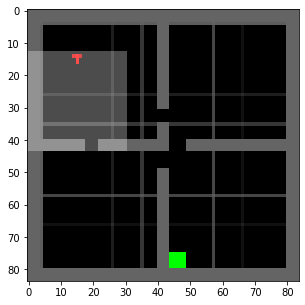

In [13]:
env.reset()
state, current_frame = preprocess(env.render(False), image_size, channel, frame_len, initial_state=True)
_ = current_frame.asnumpy().transpose([1,2,0])
# _ = np.concatenate([current_frame.asnumpy(), current_frame.asnumpy(), current_frame.asnumpy()]).transpose([1,2,0])
render_image(_, True)

In [ ]:
# Whether to render Frames and show the game
_render = False
while epis_count < max_frame:
    mx.nd.waitall()
    cum_clipped_reward = 0
    cum_reward = 0
    env.reset()
    next_frame = env.env.render(False)
    # next_frame = env.env.get_obs_render(env.env.gen_obs()["image"])
    state, current_frame = preprocess(next_frame, image_size, channel, frame_len, initial_state=True)
    t = 0.
    done = False
    initial_state = True
    location = [env.env.agent_pos.tolist()]
    while not done:
        # prepare input
        previous_state = state
        # show the frame
        render_image(current_frame.asnumpy().transpose([1,2,0]), _render)
        sample = random.random()
        if frame_counter > replay_start_size:
            annealing_count += 1
        if frame_counter == replay_start_size:
            print("annealing and learning are started tot = %.4f" % average)
        eps = np.maximum(1. - annealing_count / annealing_end, epsilon_min)
        effective_eps = eps
        if t < no_op_max:
            effective_eps = 1.
        step_count = env.env.max_steps - env.env.step_count        
        # epsilon greedy policy
        if sample < effective_eps:
            action = random.randint(0, num_action - 1)
        else:
            data = [nd.array(state.reshape([1, frame_len * channel, image_size, image_size]), ctx), nd.array([step_count], ctx)]
            action = int(nd.argmax(dqn(*data), axis=1).as_in_context(mx.cpu()).asscalar())
            
        # Skip frame
        rew = 0
        for skip in range(skip_frame):
            next_frame, reward, done, _ = env.step(action)
            render_image(next_frame, _render)
            cum_clipped_reward += rew_clipper(reward, location)
            rew += reward
            location.append(env.env.agent_pos.tolist())
        cum_reward += rew
        
        # Reward clipping
        reward = rew_clipper(rew, location)
        # End Reward clipping
        
        # _ = env.env.get_obs_render(env.env.gen_obs()["image"])
        _ = env.env.render(False)
        state, current_frame = preprocess(_, image_size, channel, frame_len, current_state=state) 
        
        # change dtype
        _ps = (previous_state * 255.).astype('uint8')
        _ac = nd.array([action]).astype('uint8')
        _s = (state * 255.).astype('uint8')
        _r = nd.array([reward])
        _d = nd.array([done])
        _sc = nd.array([step_count])
        replay_memory.push(_ps, _ac, _s, _r, _d, _sc)

        # Train
        if frame_counter > replay_start_size and frame_counter % learning_frequency == 0:
            batch = replay_memory.sample(batch_size, ctx)
            batch_state = batch.state.astype('float32') / 255
            batch_state_next = batch.state_next.astype('float32') / 255
            batch_action = batch.action
            batch_battery  = batch.battery
            batch_reward = batch.reward
            batch_finish = batch.finish
            with autograd.record():
                argmax_Q = nd.argmax(dqn(batch_state_next, batch_battery),axis = 1).astype('uint8')
                Q_sp = nd.pick(target_dqn(batch_state_next, batch_battery),argmax_Q,1)
                Q_sp = Q_sp*(nd.ones(batch_size,ctx = ctx)-batch_finish)
                Q_s_array = dqn(batch_state, batch_battery)
                Q_s = nd.pick(Q_s_array,batch_action,1)
                loss = nd.mean(loss_f(Q_s ,  (batch_reward + gamma *Q_sp)))
            loss.backward()
            trainer.step(batch_size)
            loss.asscalar()
        t += 1
        frame_counter += 1
        
        # Save the model and update Target model
        if frame_counter >replay_start_size and frame_counter % target_update == 0:
            check_point = frame_counter / (target_update * 100)
            file_name = './data/target_%s_%d' % (env_name, int(check_point))
            dqn.save_parameters(file_name)
            target_dqn.load_parameters(file_name, ctx)
        if done:
            tot_step.append(t+1)
            if epis_count % 50. == 0. :
                print('epis[%d],eps[%.4f],durat[%d],fnum=%d,tot_cl=%.4f,tot=%.4f,last_cl=%.4f,last=%.4f' %(epis_count,eps,np.mean(tot_step),frame_counter,average_clipped,average, last_clipped, last))
        if frame_counter == 1000000:
            np.save("frame_count_record_%s_Model_%d" % (env_name, model_n), frame_count_record)
            np.save("tot_clipped_reward_%s_Model_%d" % (env_name, model_n), tot_reward)
            np.save("tot_reward_%s_Model_%d" % (env_name, model_n), tot_reward)
            np.save("tot_step_%s_Model_%d" % (env_name, model_n), tot_step)
            with open("./model_%d_memory.pkl" % model_n, "wb") as f:
                pickle.dump([list(i) for i in replay_memory.memory], f)  
    epis_count += 1
    tot_clipped_reward = np.append(tot_clipped_reward, cum_clipped_reward)
    tot_reward = np.append(tot_reward, cum_reward)
    frame_count_record = np.append(frame_count_record,frame_counter)
    if epis_count > 100.:
        average_clipped = np.mean(tot_clipped_reward)
        average = np.mean(tot_reward)
        last_clipped = np.mean(tot_clipped_reward[-100:])
        last = np.mean(tot_reward[-100:])

epis[0],eps[1.0000],durat[101],fnum=100,tot_cl=0.0000,tot=0.0000,last_cl=0.0000,last=0.0000
epis[50],eps[1.0000],durat[94],fnum=4753,tot_cl=0.0000,tot=0.0000,last_cl=0.0000,last=0.0000
epis[100],eps[1.0000],durat[96],fnum=9654,tot_cl=0.0000,tot=0.0000,last_cl=0.0000,last=0.0000
epis[150],eps[1.0000],durat[98],fnum=14654,tot_cl=0.1693,tot=0.0308,last_cl=-1.8103,last=0.0099
epis[200],eps[1.0000],durat[97],fnum=19410,tot_cl=0.7482,tot=0.0365,last_cl=-0.1178,last=0.0270
epis[250],eps[1.0000],durat[98],fnum=24393,tot_cl=0.0754,tot=0.0303,last_cl=-0.0655,last=0.0295
epis[300],eps[1.0000],durat[97],fnum=29153,tot_cl=0.4580,tot=0.0337,last_cl=-0.1224,last=0.0281
epis[350],eps[1.0000],durat[97],fnum=33774,tot_cl=1.1048,tot=0.0402,last_cl=3.6784,last=0.0651
epis[400],eps[1.0000],durat[97],fnum=38668,tot_cl=0.9407,tot=0.0387,last_cl=2.3886,last=0.0536
epis[450],eps[1.0000],durat[97],fnum=43573,tot_cl=0.7463,tot=0.0365,last_cl=-0.5086,last=0.0237
epis[500],eps[1.0000],durat[97],fnum=48545,tot_cl=0

epis[4250],eps[0.6413],durat[97],fnum=408724,tot_cl=1.6770,tot=0.0415,last_cl=1.2030,last=0.0349
epis[4300],eps[0.6365],durat[97],fnum=413533,tot_cl=1.6560,tot=0.0414,last_cl=-0.5105,last=0.0199
epis[4350],eps[0.6320],durat[97],fnum=417952,tot_cl=1.7756,tot=0.0425,last_cl=5.9660,last=0.0835
epis[4400],eps[0.6273],durat[97],fnum=422682,tot_cl=1.7950,tot=0.0427,last_cl=7.7744,last=0.1011
epis[4450],eps[0.6225],durat[97],fnum=427456,tot_cl=1.8036,tot=0.0428,last_cl=3.0178,last=0.0536
epis[4500],eps[0.6178],durat[97],fnum=432214,tot_cl=1.8229,tot=0.0429,last_cl=3.0502,last=0.0519
epis[4550],eps[0.6133],durat[96],fnum=436724,tot_cl=1.9013,tot=0.0436,last_cl=6.2505,last=0.0829
epis[4600],eps[0.6087],durat[96],fnum=441330,tot_cl=1.9475,tot=0.0441,last_cl=7.5528,last=0.0958
epis[4650],eps[0.6039],durat[96],fnum=446139,tot_cl=1.9477,tot=0.0440,last_cl=4.0580,last=0.0617
epis[4700],eps[0.5990],durat[96],fnum=450964,tot_cl=1.9421,tot=0.0440,last_cl=1.6937,last=0.0389
epis[4750],eps[0.5942],durat[

In [ ]:
print(dqn.map[0:2](data[0]).shape)
print(dqn.map[0:5](data[0]).shape)
print(dqn.map[0:8](data[0]).shape)

In [ ]:
len(replay_memory.memory)

### Plot the overall performace

In [ ]:
num_epis_count = epis_count - 0
bandwidth = 100  # Moving average bandwidth
total_clipped = np.zeros(int(num_epis_count) - bandwidth)
total_rew = np.zeros(int(num_epis_count) - bandwidth)
for i in range(int(num_epis_count) - bandwidth):
    total_clipped[i] = np.sum(tot_clipped_reward[i:i + bandwidth]) / bandwidth
    total_rew[i] = np.sum(tot_reward[i:i + bandwidth]) / bandwidth
t = np.arange(int(num_epis_count) - bandwidth)
fig = plt.figure()
belplt = plt.plot(t, total_rew[0:int(num_epis_count) - bandwidth], "r", label="Return")
plt.legend()  #handles[likplt,belplt])
print('Running after %d number of episodes' % epis_count)
plt.xlabel("Number of episode")
plt.ylabel("Average Reward per episode")
plt.show()
fig.savefig('Assualt_DDQN.png')
fig = plt.figure()
likplt = plt.plot(t, total_clipped[0:num_episode - bandwidth], "b", label="Clipped Return")
plt.legend()  #handles[likplt,belplt])
plt.xlabel("Number of episode")
plt.ylabel("Average clipped Reward per episode")
plt.show()
fig.savefig('DDQN_Clipped.png')
print(max(total_rew[0:int(num_epis_count) - bandwidth]))